<a href="https://colab.research.google.com/github/zcry332/Neural_Network/blob/main/NN_BankingProject_G3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.preprocessing

dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
df = pd.read_csv(dataset_url)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
# Show ALL columns (no more '...')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Expand the width of the print output so lines don't wrap weirdly
pd.set_option('display.width', 1000)

# Show long text in cells, stop it from cutting off
pd.set_option('display.max_colwidth', None)

# Set an universal plotting size and resolution
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 100

In [3]:
# Missing value check
num_null = df.isnull().sum().max()

# Duplicated values check
num_duplicates = df.duplicated().sum()
print(f"\nNumber of null values: {num_null}")
print(f"\nTotal transactions: {len(df)}")
print(f"\nFeatures: {df.shape[1]-1}")
print(f"\nNumber of duplicated: {num_duplicates}")

# dup = df[df.duplicated()].head()

# print(f'\n {df[df.duplicated()].head(10)}')



Number of null values: 0

Total transactions: 284807

Features: 30

Number of duplicated: 1081


In [50]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

print(f"Descriptive statistics\n{df.describe()}")
print(f'{df.shape}')

Descriptive statistics
                Time             V1             V2             V3             V4             V5             V6             V7             V8             V9            V10            V11            V12            V13            V14            V15            V16            V17            V18            V19            V20            V21            V22            V23            V24            V25            V26            V27            V28         Amount          Class     log_amount      norm_time
count  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  283726.000000  2837

From above, the v1 to v28 are data which has been engineered by PCA(Principal COmponenet Analysis), with likely centered around 0. We would use PCC to check their correlation later for further feature engineering.
However, the *time* and *Amount* have to be normalized before training, which the former one is a contiuously growing number, with half of total number of reapperance, and the latter has a wide ranges from $0 to $25691. Additionally, *time* seems like a counter of seconds, this is very useless to a model because transactions would appear at anytime in day, but **Fraud** is often cyclical, which means at a certain time at a day it will reoccur, typically around 3:00 and 2:00 PM due to online search reports.



In [5]:
correlation_matrixA= df.corr()

# Get correlations with the 'Class' column and sort them
class_correlations = correlation_matrixA['Class'].sort_values(ascending=False)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrixA, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)


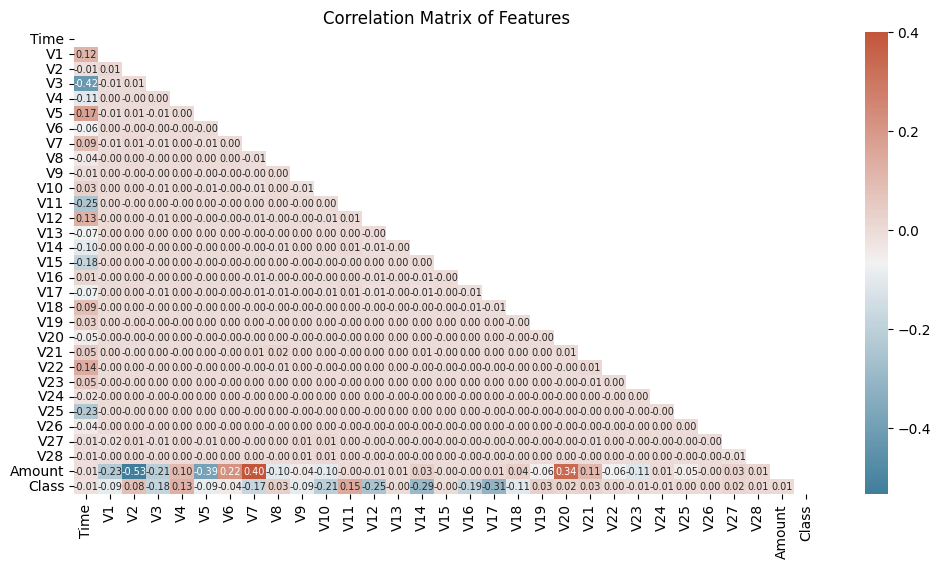

In [39]:
sns.heatmap(
    correlation_matrixA,
    mask=mask,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    annot_kws={'size':7}
    )
plt.title('Correlation Matrix of Features')
plt.show()

Through the Pearson Correlation Coefficient matrix, we can see that v22 to v26 have zero correlation to 'Class'; v2, v5, and v7 somehow have a strong relationship with 'Amount'; v3 is quite tied with 'Time'; each of the features from v1 to v28 has no interrelation, which is scaled from -0.01 to 0.01.

Now, we can define a preprocessing on data about 'Time' and 'Amount'

In [6]:
# Feature engineering the 'Time' and 'Amount'
# The original time is covered over 172792 seconds, which is 48 hours, arranged in ascending order, which is candid right skewed.
def proc_data(df):
  df['log_amount'] = np.log(df['Amount'] + 0.0001) # add 0.0001 avoid log(0) error
  # Fixed syntax: Use np.round for 2 decimal precision instead of invalid np.float.2f
  df['norm_time'] = df['Time'].apply(lambda x: np.round((x / 3600) % 24, 2))

proc_data(df)
df.sample(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,log_amount,norm_time
71074,54141.0,-0.514842,1.212165,1.140435,0.415101,0.617586,-0.159545,1.081794,-0.000187,-1.143990,-0.172451,1.493693,0.817394,-0.025461,0.604467,-0.003126,-0.270508,-0.309025,-0.491395,-0.053603,-0.115649,-0.153222,-0.541158,-0.046698,-0.036665,-0.072480,-0.688948,-0.067558,0.041924,19.97,0,2.994236,15.04
253128,156100.0,-2.179721,1.481392,-1.334336,-0.950835,0.243579,-0.337463,0.267240,1.067101,-0.651305,-1.065144,-0.193499,0.453635,-0.972768,1.662889,-0.528955,0.075843,-0.247843,0.646928,0.356979,-0.661355,0.334832,0.425528,-0.417227,0.224075,0.506995,-0.581797,-0.737118,-0.191180,39.99,0,3.688632,19.36
265767,162042.0,1.786053,-1.831490,0.141067,-0.564848,-1.639522,0.787218,-1.650933,0.383310,0.834084,0.562460,0.355898,0.580979,0.012891,-1.079104,-1.874941,0.972518,0.383340,-0.888574,1.051887,0.245309,0.260298,0.725145,0.142879,0.749321,-0.406268,-0.242921,0.034387,-0.016638,142.87,0,4.961936,21.01
271467,164587.0,1.929517,-0.888827,-0.776189,-1.941460,-0.916462,-1.125517,-0.414030,-0.260507,2.322868,-1.347820,0.022606,1.737871,1.541944,-0.192848,1.673214,-0.758661,-0.350802,0.243626,0.557148,0.051221,0.316271,1.087999,0.081437,1.221851,0.030223,-0.815056,0.070225,-0.010815,74.26,0,4.307574,21.72
79571,58079.0,1.352738,-0.422127,-0.187631,-0.677298,-0.498399,-0.876589,-0.110482,-0.278353,-1.148234,0.617250,0.018704,-0.375507,0.408716,0.045865,0.645727,0.438258,0.663738,-2.010664,0.234822,0.104509,0.284139,0.760805,-0.185328,0.133818,0.741266,-0.013243,-0.011486,0.003907,39.00,0,3.663564,16.13
119689,75545.0,-1.111477,0.752268,1.856310,-0.308096,0.494639,0.832870,1.367392,-0.430387,0.977124,1.375949,1.600391,0.132572,-1.322247,-0.801274,-0.323321,-1.128419,-0.030437,-0.984738,-0.104854,0.540510,-0.431048,0.044585,-0.153626,-0.292961,-0.153780,0.191924,0.063844,-0.560817,64.44,0,4.165736,20.98
160933,113738.0,2.040237,-0.542058,-1.282358,-0.588118,-0.182781,-0.487989,-0.240965,-0.052302,1.063788,-0.131719,0.651996,0.913903,-0.667411,0.282324,-0.975977,-0.368461,-0.178342,-0.050274,0.818699,-0.188862,0.092614,0.482305,0.101907,0.857081,-0.008887,0.946749,-0.100519,-0.078039,9.00,0,2.197236,7.59
41182,40571.0,-1.705264,0.876476,2.009100,-0.026554,-1.126270,1.432179,-1.831837,-4.193077,-0.965431,0.416738,-1.481893,-0.411614,0.552981,-0.261164,1.667429,-0.739976,-0.381893,2.470214,-0.546898,-0.011910,-0.023077,0.094904,-0.097475,-0.491794,0.198956,-0.071758,0.439936,-0.088873,100.00,0,4.605171,11.27
45511,42381.0,1.120277,-0.145638,-0.687056,-0.004509,0.194753,-0.863284,0.688454,-0.455414,-0.306423,-0.182163,-0.760513,0.593886,1.513172,0.195319,0.691197,0.107166,-0.534679,-0.553829,0.382695,0.311034,-0.005716,-0.230256,-0.324996,-0.329958,0.657293,1.103793,-0.131637,0.008868,142.95,0,4.962496,11.77
23881,32966.0,-1.467231,0.837788,2.684095,-0.005974,0.234809,2.100363,-0.602445,-2.996596,1.616490,-0.028002,-1.698541,0.597411,0.529427,-1.971945,-1.492881,-0.972060,0.068204,-0.756553,0.589840,1.152409,-1.705497,0.435452,-0.289045,-0.895929,0.324000,0.378821,-0.517954,-0.632675,7.79,0,2.052854,9.16


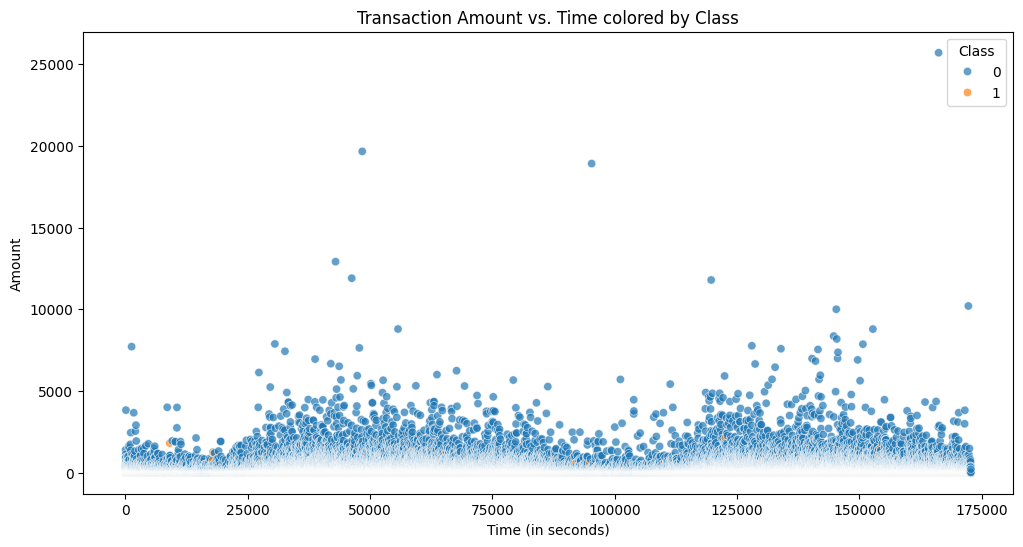

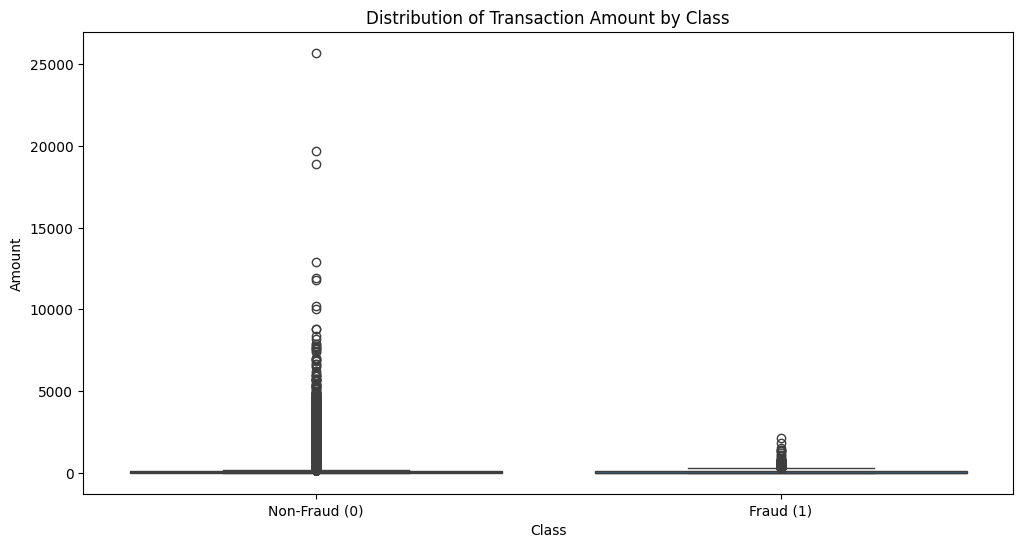

In [40]:
# spot outliers using time and amount, analyze relationship between 'Time', 'Amount', and 'Class'
sns.scatterplot(x='Time', y='Amount', hue='Class', data=df, alpha=0.7)
plt.title('Transaction Amount vs. Time colored by Class')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

# Analyze the distribution of 'Amount' for each class, boxplot shows the relationship between class and amount.
# Superisingly the excessive amount is not fraud, and fraud values are embeding in quite small amount clustered under 3000
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Distribution of Transaction Amount by Class')
plt.xlabel('Class')
plt.ylabel('Amount')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

We can see if we use original 'Time' and 'Amount' to plot the distribution of each transaction, they tell me little about anything. However, we can inspect the data by using normalized data below.



In [9]:
# Since it is hard to visually have a concept that how inblance the data frame is, we can count the value in each 'Class'
class_counts = df['Class'].value_counts()
print(class_counts)

Class
0    283253
1       473
Name: count, dtype: int64


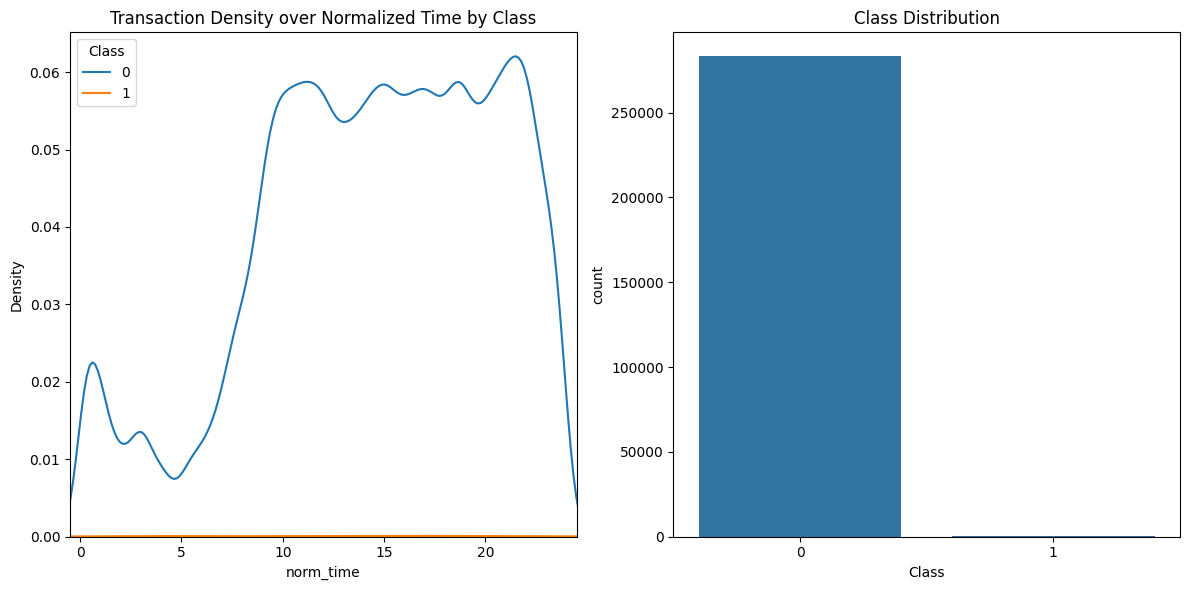

In [41]:
# Now we have a impression that the Fraud transaction is just teenie tiny chunk of observations in the data frame
# Let's plot again with the normalized time and amount
fig, axs = plt.subplots(1, 2,)

# KDE Plot for Time.
sns.kdeplot(data=df, x='norm_time', hue='Class', ax=axs[0]).set(title="Transaction Density over Normalized Time by Class", xlim=(-0.5,24.5))

# Count Plot for Class Balance
# Changed x to 'Class' to correctly show the number of samples per class
sns.countplot(data=df, x='Class', fill = 'Class', ax=axs[1]).set(title ='Class Distribution')
plt.tight_layout()
plt.show()

The data has been scaled into a readable range, but the total number of fraud cases is so small that it can barely be discerned from those plots. Therefore, we try a different approach to re-examine the data frame.

It becomes obvious that most outliners are non-fraud, and fraud transactions are so shrewd to be embedded in the massive non-fraud transactions. Yet, the medians of 'log_amount' in both categories suggest that the fraud transactions are slightly lower than normal ones, with a wide range.

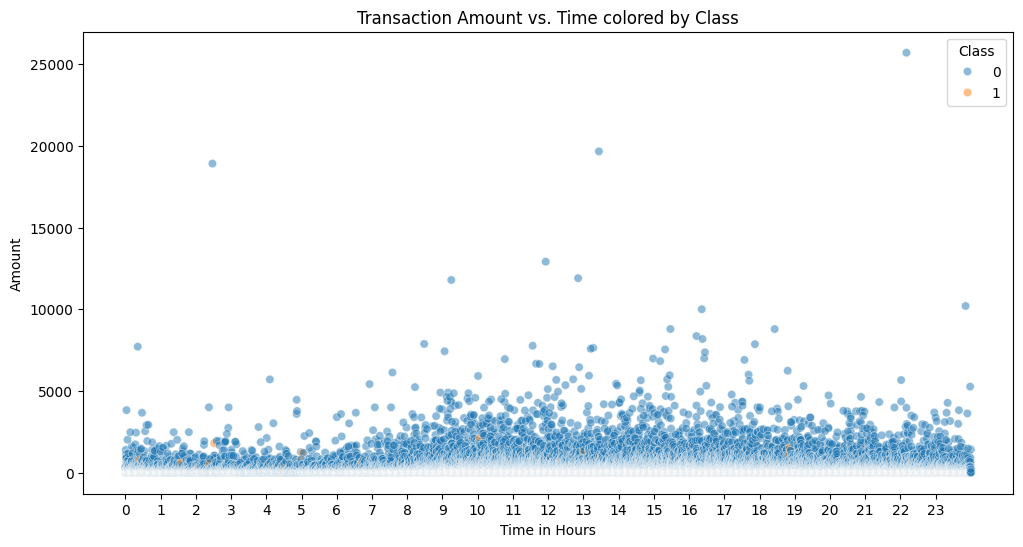

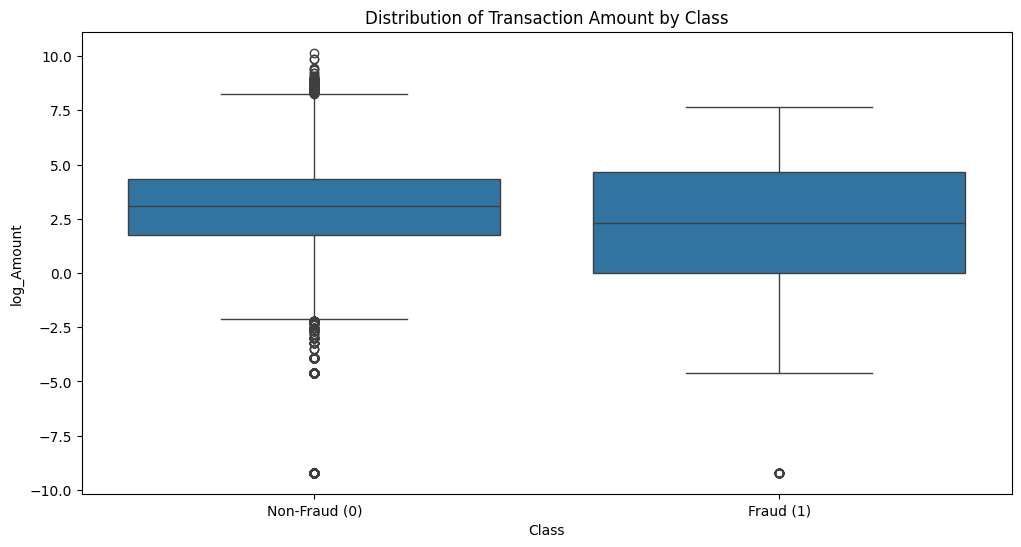

In [42]:
# Analyze the distribution of normalized time in hours.
sns.scatterplot(x='norm_time', y='Amount', hue='Class', data=df, alpha=0.5)
plt.title('Transaction Amount vs. Time colored by Class')
plt.xticks(np.arange(0, 24, 1))
plt.xlabel('Time in Hours')
plt.ylabel('Amount')
plt.show()

# Analyze the distribution of 'normalized_amount' for each class, boxplot shows the relationship between class and amount.
sns.boxplot(x='Class', y='log_amount', data=df)
plt.title('Distribution of Transaction Amount by Class')
plt.xlabel('Class')
plt.ylabel('log_Amount')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

In [51]:
# I naively start to train our model with manually build a Forword Feeding Neural Network
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LeakyReLU, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

RANDOM_SEED = 42
# Separate features X and target y
X = df.drop(['Class', 'Time', 'Amount'], axis=1)
y = df['Class']


print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")

# train/test split to get 20% of data to be test data, since the output of this model is binary, use STRATIFY to prevent bias
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

print(f'Preview of X_train:\n {X_train.sample(5)}')
print(f'\nNumber of X_train: {X_train.shape, sum(y_train == 1)}, Number of X_test: {X_test.shape, sum(y_test == 1)}')

Shape of features (X): (283726, 30)
Shape of target (y): (283726,)
Preview of X_train:
               V1        V2        V3        V4        V5        V6        V7        V8        V9       V10       V11       V12       V13       V14       V15       V16       V17       V18       V19       V20       V21       V22       V23       V24       V25       V26       V27       V28  log_amount  norm_time
21604   1.234633  0.100987  0.040961  1.269732 -0.040489 -0.190705  0.074143 -0.040938  0.518873 -0.054238 -1.697871 -0.424296 -1.075539  0.212518 -0.160244 -0.131584 -0.255637 -0.115508  0.309196 -0.169409 -0.187515 -0.425163 -0.196218 -0.463965  0.804328 -0.288487  0.011925  0.011396    3.208021       8.82
73049   1.214528  0.292677  0.274219  0.645071 -0.203705 -0.608484 -0.007009 -0.052522  0.062156 -0.319964  0.117518  0.203193 -0.013803 -0.215617  1.369899  0.196315  0.285591 -0.721275 -0.555000 -0.128211 -0.262997 -0.733128  0.162197  0.027863  0.136139  0.124941 -0.007876  0.026800   -0.

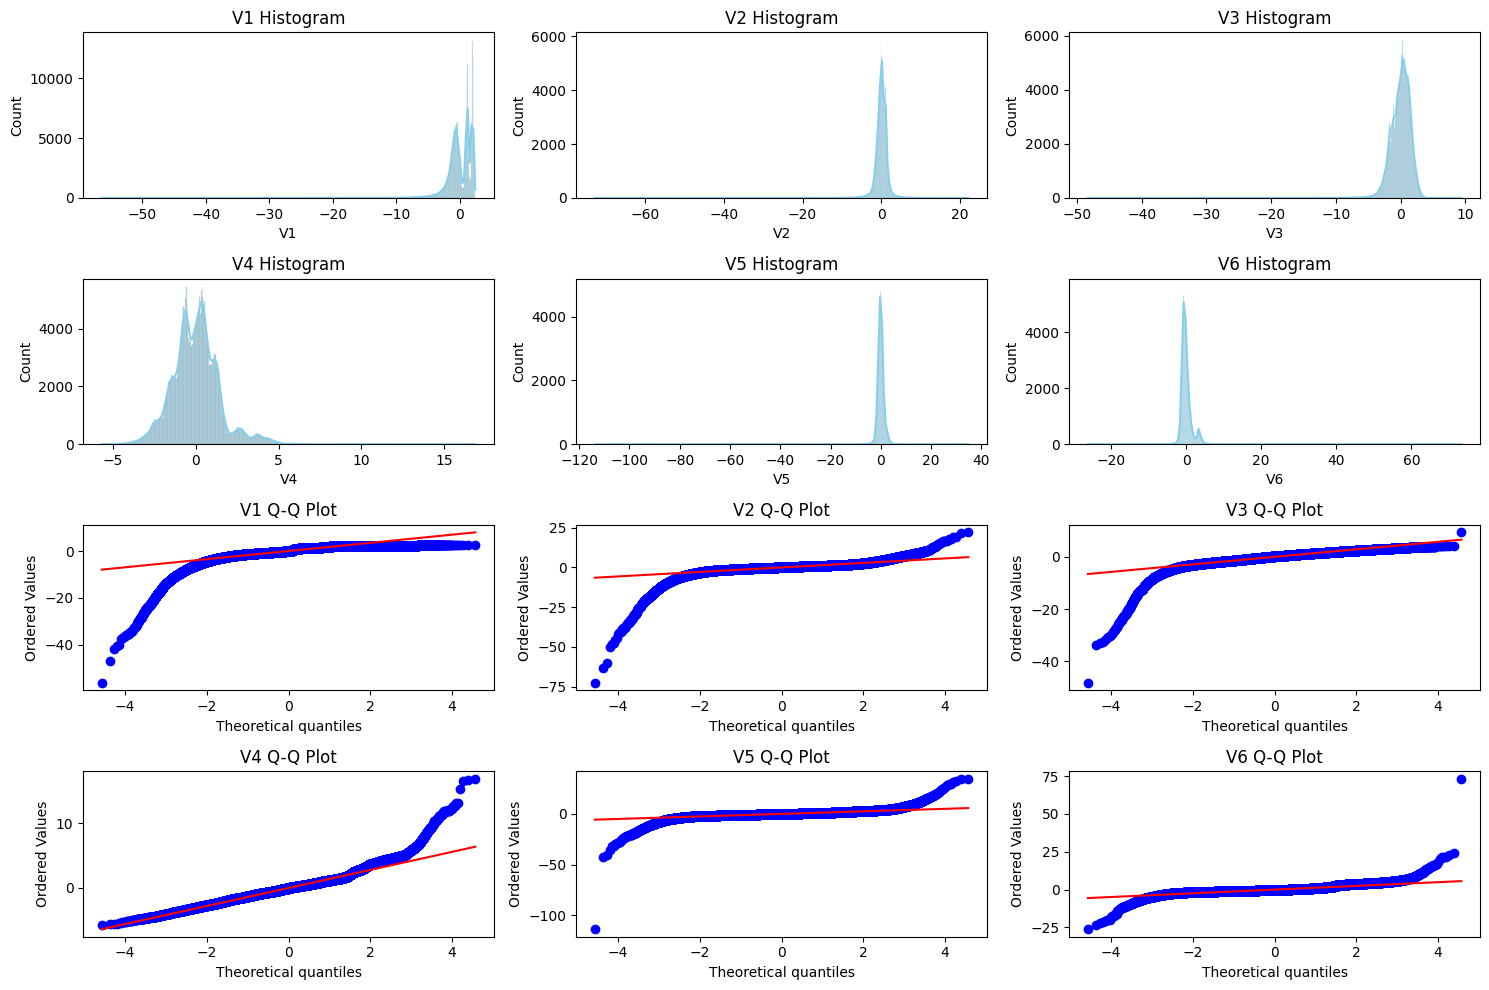

In [ ]:
import scipy.stats as stats

# Pick a few features to compare (Limit to first 3 to fit the 2x3 grid)
features_to_check = X.drop(columns=['norm_time', 'log_amount'], axis=1).iloc[:, :6]

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_to_check):
    # 1. Histogram (Top Row)
    # 2 rows, 3 columns, index i+1
    plt.subplot(4, 3, i+1)
    sns.histplot(df[feature], kde=True, color='skyblue')
    plt.title(f'{feature} Histogram')

    # 2. Q-Q Plot (Bottom Row)
    # 2 rows, 3 columns, index i+7 (shifted by 3 for the third row)
    plt.subplot(4, 3, i+7)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.title(f'{feature} Q-Q Plot')

plt.tight_layout()
plt.show()

In [105]:
# Since the dataset is all numerical, therefore, there is no encoding categorical variables for training
# I think there is no embeding necessary for this dataset as well
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_temp_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [106]:
# create the model
def create_FFNN(input_dim):
   # Creates a Feedforward Neural Network model.
    model = keras.Sequential([
        keras.Input(shape=(input_dim,)),
        layers.Dense(64, activation=LeakyReLU(negative_slope=0.1)),
        # layers.Dense(32, activation=LeakyReLU(negative_slope=0.01)),
        layers.Dense(32, activation='linear'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid') # Changed to 1 neuron with sigmoid for binary classification
    ])
    return model

In [107]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# because we would use validation split while training, we would use X_temp for training
# calculate class weights based on the ORIGINAL (imbalanced) training data, y_temp is our raw 0/1 label
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(class_weight_dict)

{np.int64(0): np.float64(0.5008340614822464), np.int64(1): np.float64(300.23809523809524)}


In [108]:
# Instantiate the model
model = create_FFNN(X_temp_scaled.shape[1])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(curve='ROC', name='auc'),
                  tf.keras.metrics.AUC(curve='PR', name='auprc')
              ])

model.summary()

# Train the model
history = model.fit(
    X_temp_scaled,
    y_train,
    epochs=50,  # You can adjust the number of epochs
    batch_size=128, # You can adjust the batch size
    validation_split=0.2, # Using a validation split for monitoring
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]# Add class weights here
)

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)               │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - auc: 0.9462 - auprc: 0.6168 - loss: 0.2505 - precision: 0.0258 - recall: 0.8596 - val_auc: 0.9810 - val_auprc: 0.7646 - val_loss: 0.1490 - val_precision: 0.0332 - val_recall: 0.9487 - learning_rate: 0.0010
Epoch 2/50
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.9893 - auprc: 0.6430 - loss: 0.1176 - precision: 0.0438 - recall: 0.9383 - val_auc: 0.9786 - val_auprc: 0.7411 - val_loss: 0.0937 - val_precision: 0.0727 - val_recall: 0.9103 - learning_rate: 0.0010
Epoch 3/50
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.9895 - auprc: 0.6791 - loss: 0.1172 - precision: 0.0517 - recall: 0.9364 - val_auc: 0.9805 - val_auprc: 0.7625 - val_loss: 0.0850 - val_precision: 0.0469 - val_recall: 0.9359 - learning_rate: 0.0010
Epoch 4/50
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.9942 - auprc: 0.6772 - loss: 0.0959 - precision: 0.0448 - recall: 0.9544 - val_auc: 0.9797 - val_auprc: 0.7857 - val_loss: 0.0893 - val_precision: 0.0

In [110]:
# Evaluate the model on the test set
loss, precision, recall, auc, auprc = model.evaluate(X_test_scaled, y_test)

# Generate predictions on the test set
y_pred = (model.predict(X_test_scaled) > 0.58).astype("int32")

# Display classification report and confusion matrix
# To control precision, use digits=4 inside classification_report()
print(f'\nClassification Report:\n {classification_report(y_test, y_pred,labels= [1,0], digits=2)}')
print(f'\nConfusion Matrix:\n {confusion_matrix(y_test, y_pred, labels=[1,0])}')

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9266 - auprc: 0.7605 - loss: 0.0085 - precision: 0.4435 - recall: 0.8385
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:
               precision    recall  f1-score   support

           1       0.44      0.80      0.57        95
           0       1.00      1.00      1.00     56651

    accuracy                           1.00     56746
   macro avg       0.72      0.90      0.79     56746
weighted avg       1.00      1.00      1.00     56746


Confusion Matrix:
 [[   76    19]
 [   95 56556]]


The model has done a good job of catching 80%+ of "Fraud" attempts, furthermore, it has not struggled to predict many "Fraud" attempts, of which only 76 are actually "Non-Fraud". With a precision score of 35% in catching "1", it means that for every 1 real criminal it catches, it may freeze the credit cards of 2 innocent person. It is a reasonable in the real world for a first attempt. However, I still seek to see if there is any other way to improve the stability and performance of this project. Let's review the test data to assess its performance again.

Besides, the model seems to be a bit problematic and over-engineering with linear function inside and using LeakyReLU as an activation. and should add regularization to reduce overfitting.

In [111]:
def plot_loss(history):
  # check the loss in terms of training
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  # plot the Loss to diagnose whether it is a overfitting
  plt.plot(train_loss, label='Train Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

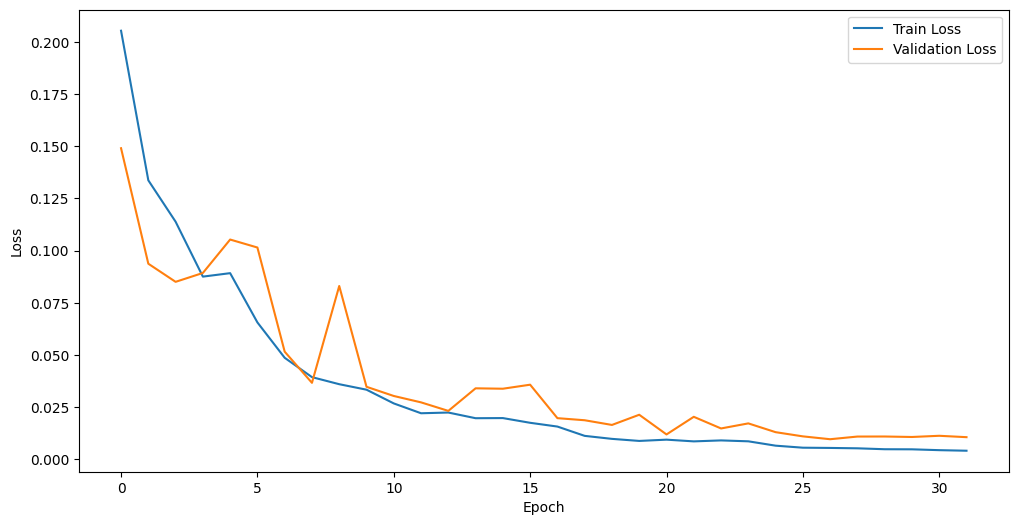

In [112]:
plot_loss(history)
# result seems quite health, the spike in epoch 14 may be a bad batch full of outliners

In [113]:
# Save the trained model
model.save('fraud_detection_model.keras')
print("Model saved successfully!")

Model saved successfully!



It has proved that it has a quite stable performance on test data, which is as the same size as validate data. is it a overfitting, or is there a better way to train a model with reasonable presion on fraud with high recall?

##What to do next?
1. Adjust the decision threshold — _e.g., only predict class if probability > 0.9 to boost precision (at the cost of recall)_;
2. Use class weighting or resampling (_**SMOTE** / **undersampling**_) to balance the data;
3. Try other loss functions (**binary focal loss**);
4. Tune architecture or regularization slightly, including more hidden units, dropout between layers, or _**BatchNormalization()_** helps stablize learning, especially for the weak minority signal.


Let's check out the first 6 features to see whether they are normal distributed, this is useful, because we just used _StandardScaler()_ to handle our data. It is sensitive to outliers, which can skew the mean and standard deviation. Since 'Fraud' observations in this dataset is not as extreme as we naively expected, the idea is that whether it is okay to use _RobustScaler()_, which is resilient to outliers.

In [114]:
# re-engineer the model
def compile_model(model,loss_function):
  """Compiles the Keras model with a predefined optimizer, loss, and metrics."""
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss= loss_function,
      metrics=[
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(curve='ROC', name='auc'),
          keras.metrics.AUC(curve='PR', name='auprc')
      ])
  return model

In [29]:
# Creates a Feedforward Neural Network model
def create_FFNN_v2(input_dim, loss_function):
  model = keras.Sequential([
      keras.Input(shape=(input_dim,)),

      # hidden layer 1
      layers.Dense(64, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.001)),
      layers.BatchNormalization(),
      layers.LeakyReLU(negative_slope=0.1),
      layers.Dropout(0.3),

      # hidden layer 2
      layers.Dense(32, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.001)),
      layers.BatchNormalization(),
      layers.LeakyReLU(negative_slope=0.1),
      layers.Dropout(0.3),

      # hidden layer 3
      layers.Dense(16, activation='relu'),

      # output layer is binary
      layers.Dense(1, activation='sigmoid')
      ])

  # compile the model with Adam, standard BCE
  model = compile_model(model, loss_function)
  return model

In [59]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

robscaler = RobustScaler()
smote = SMOTE(random_state=RANDOM_SEED)
# first, I would adopt cross-validation
# second, I would use RobustScaler for mitigate the sensitivity of outliers, since Fraud transaction is normally acted like normal transaction
# third, I would try to oversampling the training dataset for model to better generalize the behavior pattern of Fraud labels by using SMOTE
def cross_val_train(X_train, y_train, epochs, batch_size, loss_function, use_smote:bool):
  KFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
  fold_histories, fold_models = [], []

  # Variables to keep track of the best model and history
  best_val_recall = -1
  best_model_overall = None
  best_hist_overall = None

  # Corrected loop with enumerate for fold index and proper f-string usage
  for fold_idx, (train_ind, val_ind) in enumerate(KFold.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_ind], X_train.iloc[val_ind]
    y_train_fold, y_val_fold = y_train.iloc[train_ind], y_train.iloc[val_ind]

    # robustscaler fit on training fold only
    X_train_fold_scaled = robscaler.fit_transform(X_train_fold)
    X_val_fold_scaled = robscaler.transform(X_val_fold)

    # SMOTE fit on training fold only
    if use_smote == True:
      X_train_sm_data, y_train_sm_data = smote.fit_resample(X_train_fold_scaled, y_train_fold)
    else:
      X_train_sm_data, y_train_sm_data = X_train_fold_scaled, y_train_fold

    # train and evaluate the model
    model_current_fold = create_FFNN_v2(X_train_fold_scaled.shape[1], loss_function)

    hist_current_fold = model_current_fold.fit(X_train_sm_data,
                          y_train_sm_data,
                          epochs=epochs,
                          batch_size=batch_size, # Changed from 256 to 64 for consistency with first model
                          validation_data=(X_val_fold_scaled, y_val_fold),
                          callbacks=[early_stopping, reduce_lr],
                          verbose=0) # Added verbose=0 to reduce output during training

    print(f'Training fold {fold_idx + 1} is complete') # Corrected f-string

    # Store model and history for this fold
    fold_models.append(model_current_fold)
    fold_histories.append(hist_current_fold)

    # Check if this fold's model is the best so far based on max validation recall
    current_fold_max_val_recall = max(hist_current_fold.history['val_recall'])
    if current_fold_max_val_recall > best_val_recall:
        best_val_recall = current_fold_max_val_recall
        best_model_overall = model_current_fold
        best_hist_overall = hist_current_fold

  # Return the best model and its history found across all folds
  return best_model_overall, best_hist_overall

model_v2, hist_v2 = cross_val_train(X_train, y_train, 50, 128, 'binary_crossentropy', use_smote=True)

Training fold 1 is complete
Training fold 2 is complete
Training fold 3 is complete
Training fold 4 is complete
Training fold 5 is complete


In [60]:
X_test_robscaled = robscaler.transform(X_test)

# no big difference between threshold with 0.5 and 0.75
loss, precision, recall, auc, auprc = model_v2.evaluate(X_test_robscaled, y_test)
y_pred = (model_v2.predict(X_test_robscaled) > 0.75).astype("int32")

print(f'\nClassification Report:\n {classification_report(y_test, y_pred,labels= [1,0], digits=2)}')
print(f'\nConfusion Matrix:\n {confusion_matrix(y_test, y_pred, labels=[1,0])}')

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.9208 - auprc: 0.7679 - loss: 0.0099 - precision: 0.6439 - recall: 0.7981
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.79      0.75        95
           0       1.00      1.00      1.00     56651

    accuracy                           1.00     56746
   macro avg       0.86      0.89      0.88     56746
weighted avg       1.00      1.00      1.00     56746


Confusion Matrix:
 [[   75    20]
 [   29 56622]]


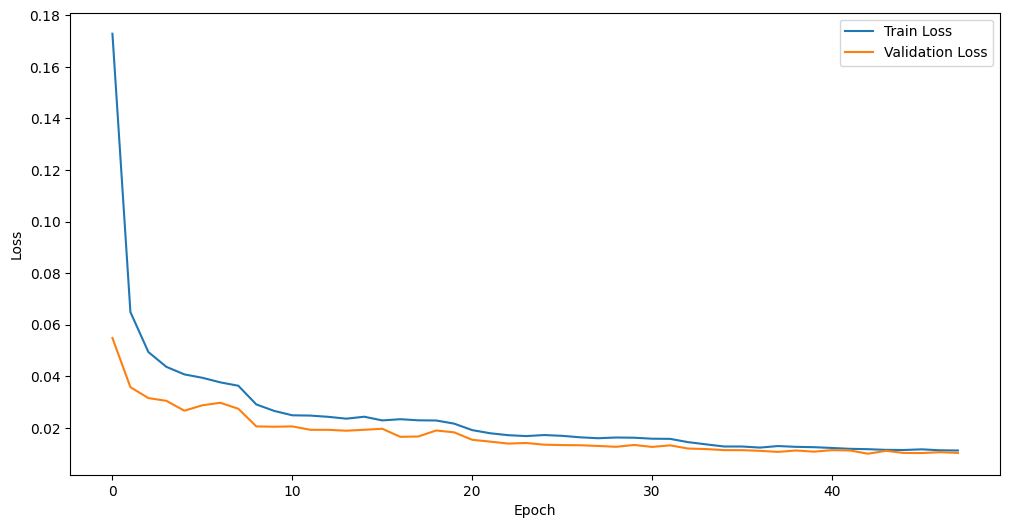

In [61]:
plot_loss(hist_v2)

In [71]:
# addtionally I want to initial a randomforest to see if clustering would identify the fraud more better
from sklearn.ensemble import RandomForestClassifier
X_train_robscaled = robscaler.fit_transform(X_train)
X_test_robscaled = robscaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, class_weight='balanced')
rf.fit(X_train_robscaled, y_train)


print(classification_report(y_test, rf.predict(X_test_robscaled),labels=[1,0]))
print(confusion_matrix(y_test, rf.predict(X_test_robscaled), labels=[1,0]))

              precision    recall  f1-score   support

           1       0.99      0.71      0.82        95
           0       1.00      1.00      1.00     56651

    accuracy                           1.00     56746
   macro avg       0.99      0.85      0.91     56746
weighted avg       1.00      1.00      1.00     56746

[[   67    28]
 [    1 56650]]


In [104]:
predict_nn = model_v2.predict(X_test_robscaled).ravel()
predict_rf = rf.predict_proba(X_test_robscaled)[:, 1]

predict_ensemble = 0.5*predict_nn + 0.5*predict_rf

print(classification_report(y_test, (predict_ensemble > 0.58).astype(int),labels=[1,0]))
print(confusion_matrix(y_test, (predict_ensemble > 0.58).astype(int), labels=[1,0]))

# the best auprc is around 0.87 when setting predict_ensemble > 0.58 or 0.59
from sklearn.metrics import precision_recall_curve, auc, f1_score
precision, recall, _ = precision_recall_curve(y_test, (predict_ensemble > 0.58))
auprc = auc(recall, precision)
print(f'\nAUPRC: {auprc}')

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

           1       0.96      0.78      0.86        95
           0       1.00      1.00      1.00     56651

    accuracy                           1.00     56746
   macro avg       0.98      0.89      0.93     56746
weighted avg       1.00      1.00      1.00     56746

[[   74    21]
 [    3 56648]]

AUPRC: 0.870178199798558


In [115]:
# save the model_v2
model_v2.save('fraud_detection_model_v2.keras')

# save the randomforestclassifier model
import joblib
joblib.dump(rf, 'rf_model.pkl')

# record the weights for evaluating the results from each model into a json file
import json
ensemble_cfg = {"weight": [0.5, 0.5]}
with open('ensemble_config.json', 'w') as f:
  json.dump(ensemble_cfg, f)
print("Model saved successfully!")

Model saved successfully!
